## Task 7 : Stock Market Prediction using Numerical and Textual Analysis


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [ ]:
columns=['Date','Category','News']
df = pd.read_csv('/content/drive/MyDrive/india-news-headlines.csv.zip',names=columns)

In [ ]:
print('Showing part of the whole dataset:')
df.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [ ]:
df.drop(0, inplace=True)
df.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
df.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3876548,20230630,Yuri: We will question govt over sacking of un...
3876549,20230630,Three of family end lives due to financial burden
3876550,20230630,7;500 students with aptitude to learn advanced...
3876551,20230630,Civic bodies told to collect labour cess


In [ ]:
hisdf = pd.read_csv('/content/drive/MyDrive/^BSESN.csv')
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,46103.500000,20700.0


In [ ]:
df["Date"] = pd.to_datetime(df["Date"],format='%Y%m%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3876557 entries, 1 to 3876557
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 59.2+ MB


In [ ]:
df['News'] = df.groupby(['Date']).transform(lambda x : ' '.join(x))
df = df.drop_duplicates()
df.reset_index(inplace=True,drop=True)

In [ ]:
df

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
8165,2023-06-26,How can loneliness worsen your mental health? ...
8166,2023-06-27,Daily Horoscope; June 27; 2023: Read your dail...
8167,2023-06-28,What is the 'courting hut' wedding ritual in A...
8168,2023-06-29,Daily Horoscope; June 29; 2023: Read your dail...


In [ ]:
df.isnull().sum()

Date    0
News    0
dtype: int64

In [ ]:
len(df)

8170

In [ ]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0
...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,20700.0


In [ ]:
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [ ]:
hisdf.describe()

,Date,Open,High,Low,Close,Volume
count,252,250.000000,250.000000,250.000000,250.000000,250.000000
mean,2020-06-18 20:22:51.428571392,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
min,2019-12-17 00:00:00,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,2020-03-17 18:00:00,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,2020-06-22 12:00:00,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,2020-09-17 06:00:00,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,2020-12-17 00:00:00,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000
std,NaN,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333


In [ ]:
hisdf.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

In [ ]:
len(hisdf)

252

Text(0, 0.5, 'BSESN')

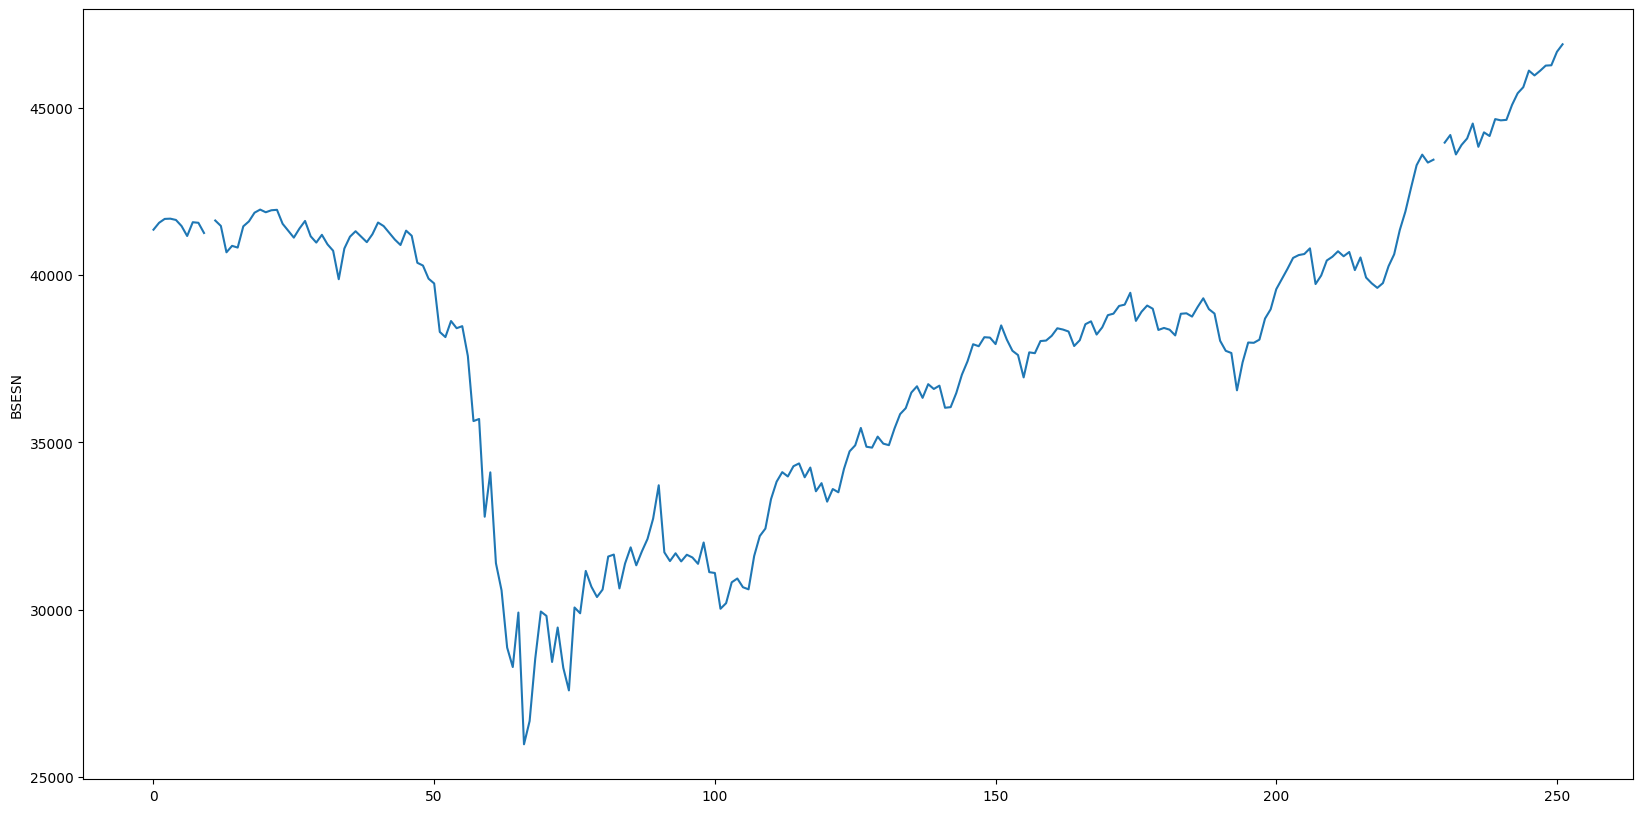

In [ ]:
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

In [ ]:
df.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
df["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

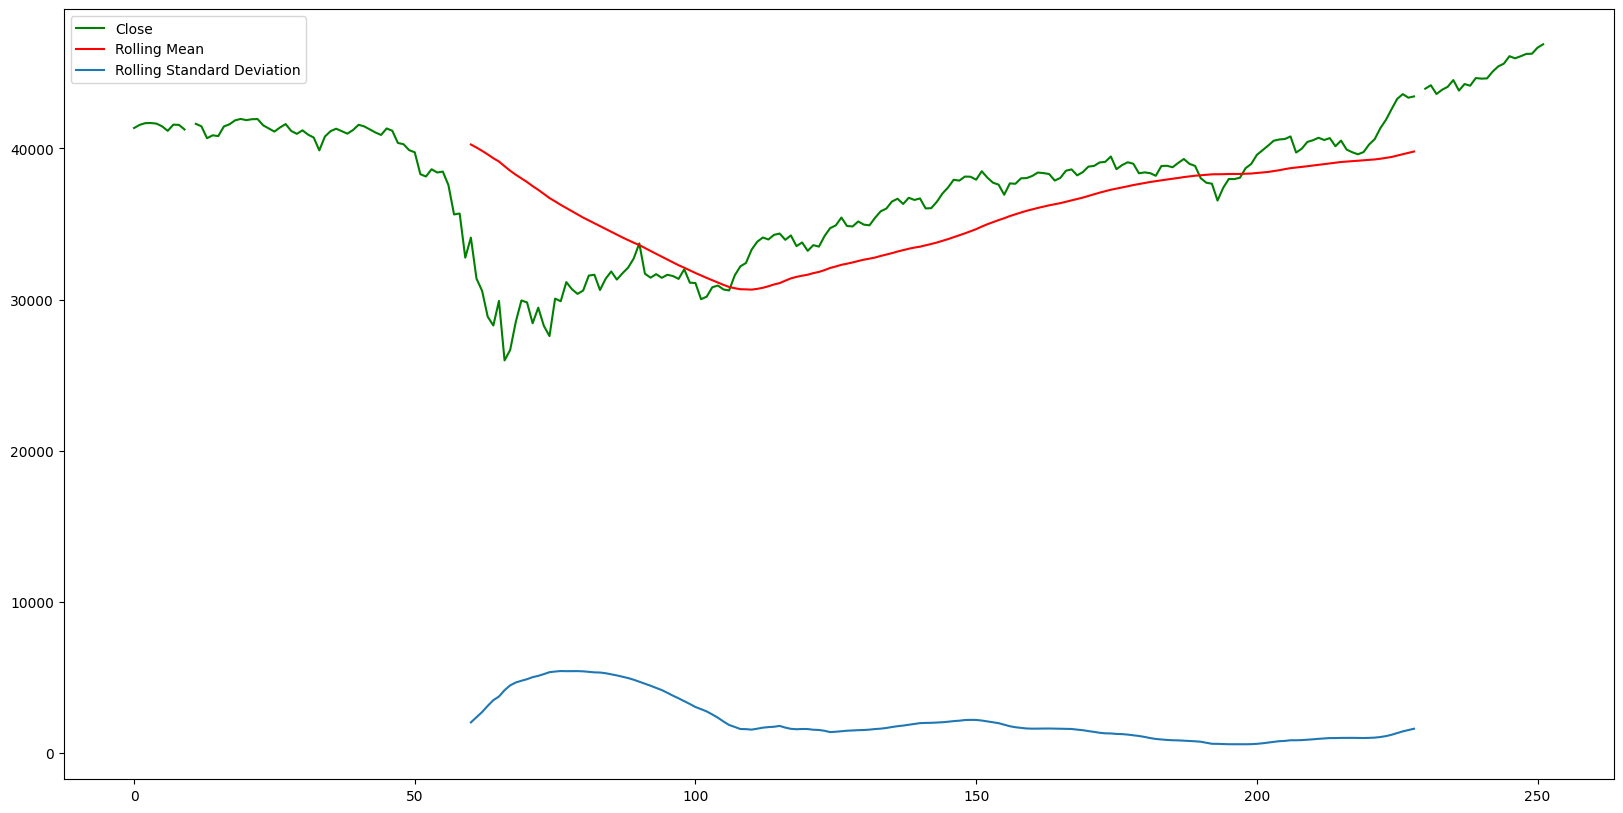

In [ ]:
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

Text(0.5, 1.0, 'Returns')

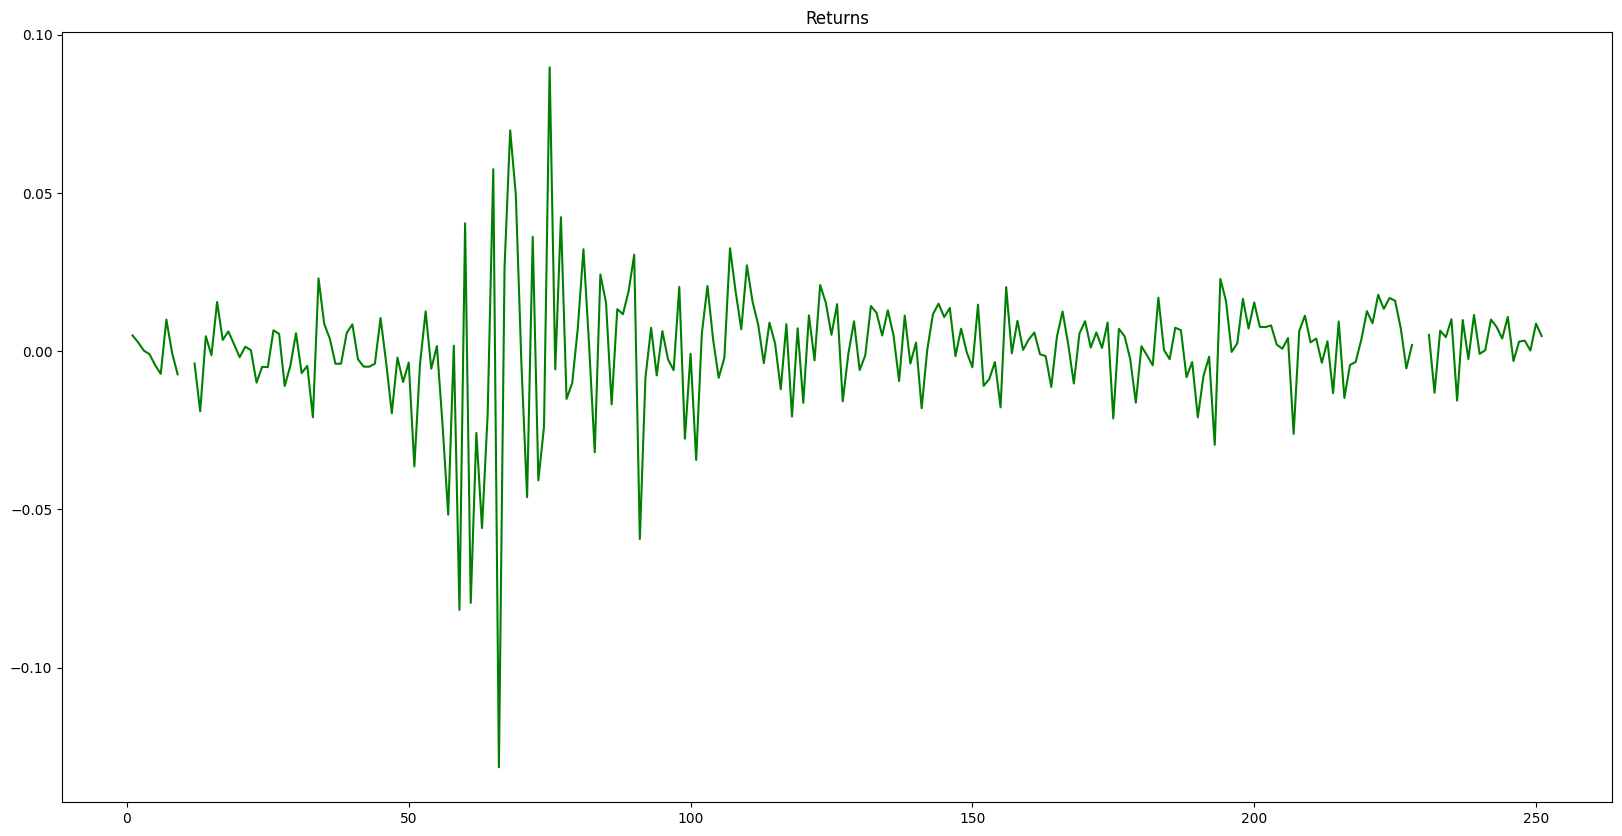

In [ ]:
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
train = hisdf[:1219]
test = hisdf[1219:]

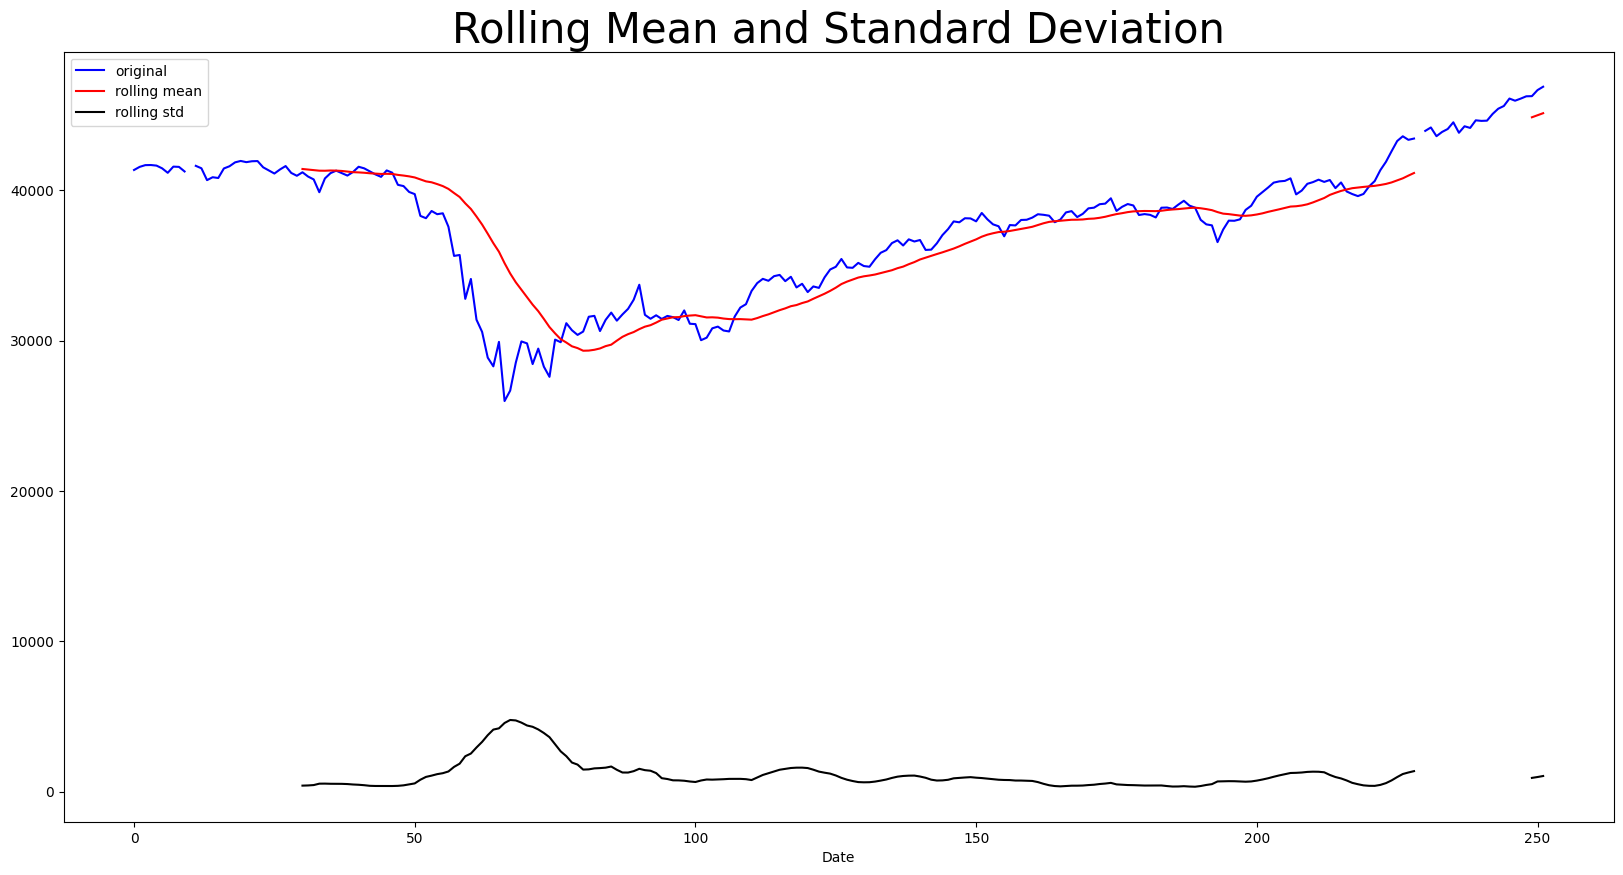

Results of dickey fuller test


NameError: name 'adfuller' is not defined

In [ ]:
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)

 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

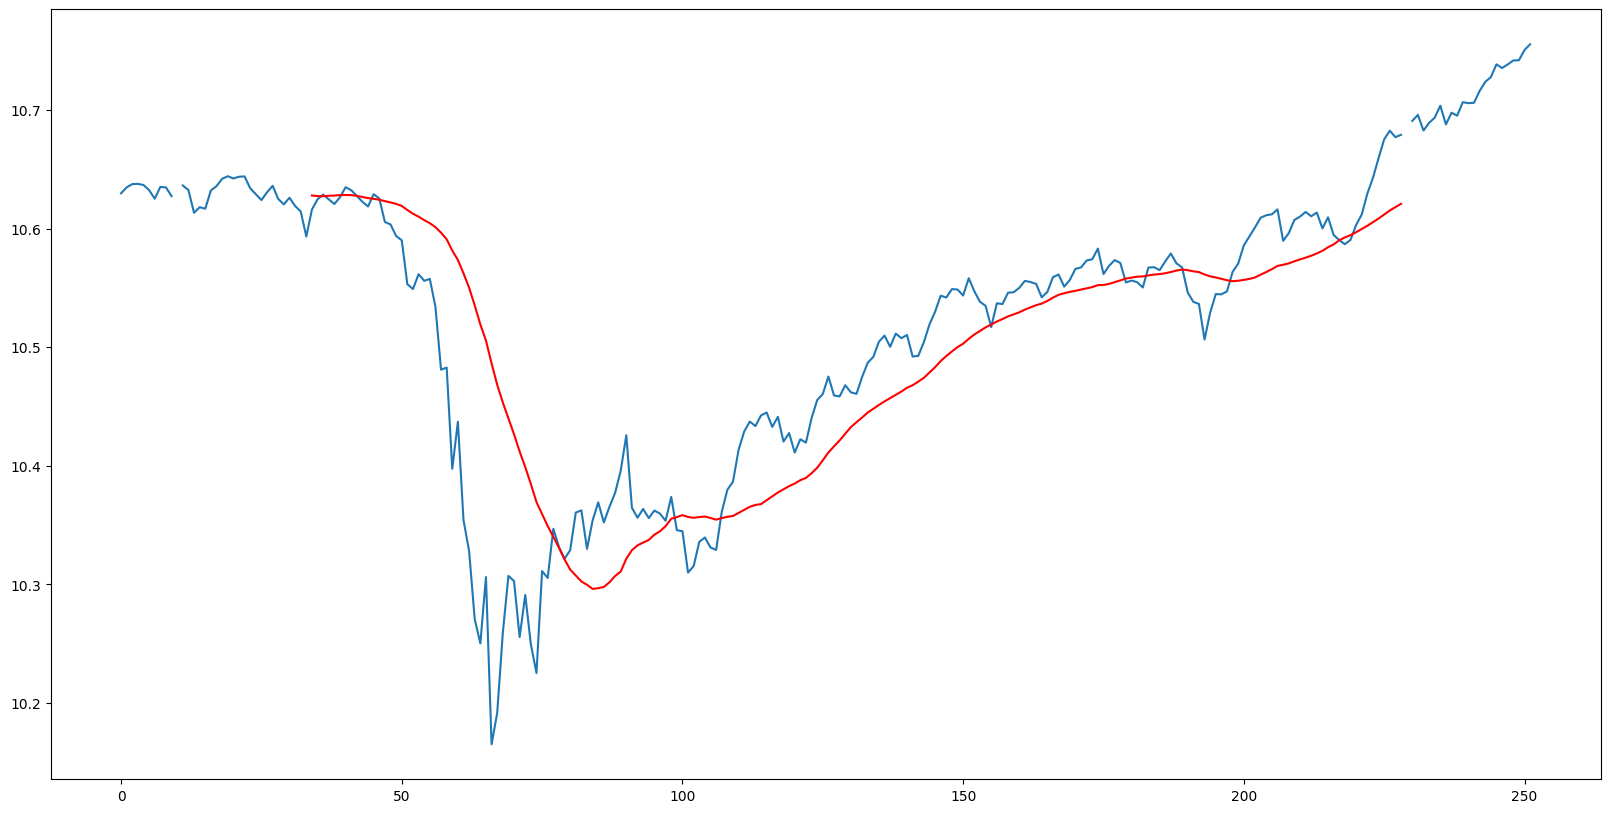

In [ ]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

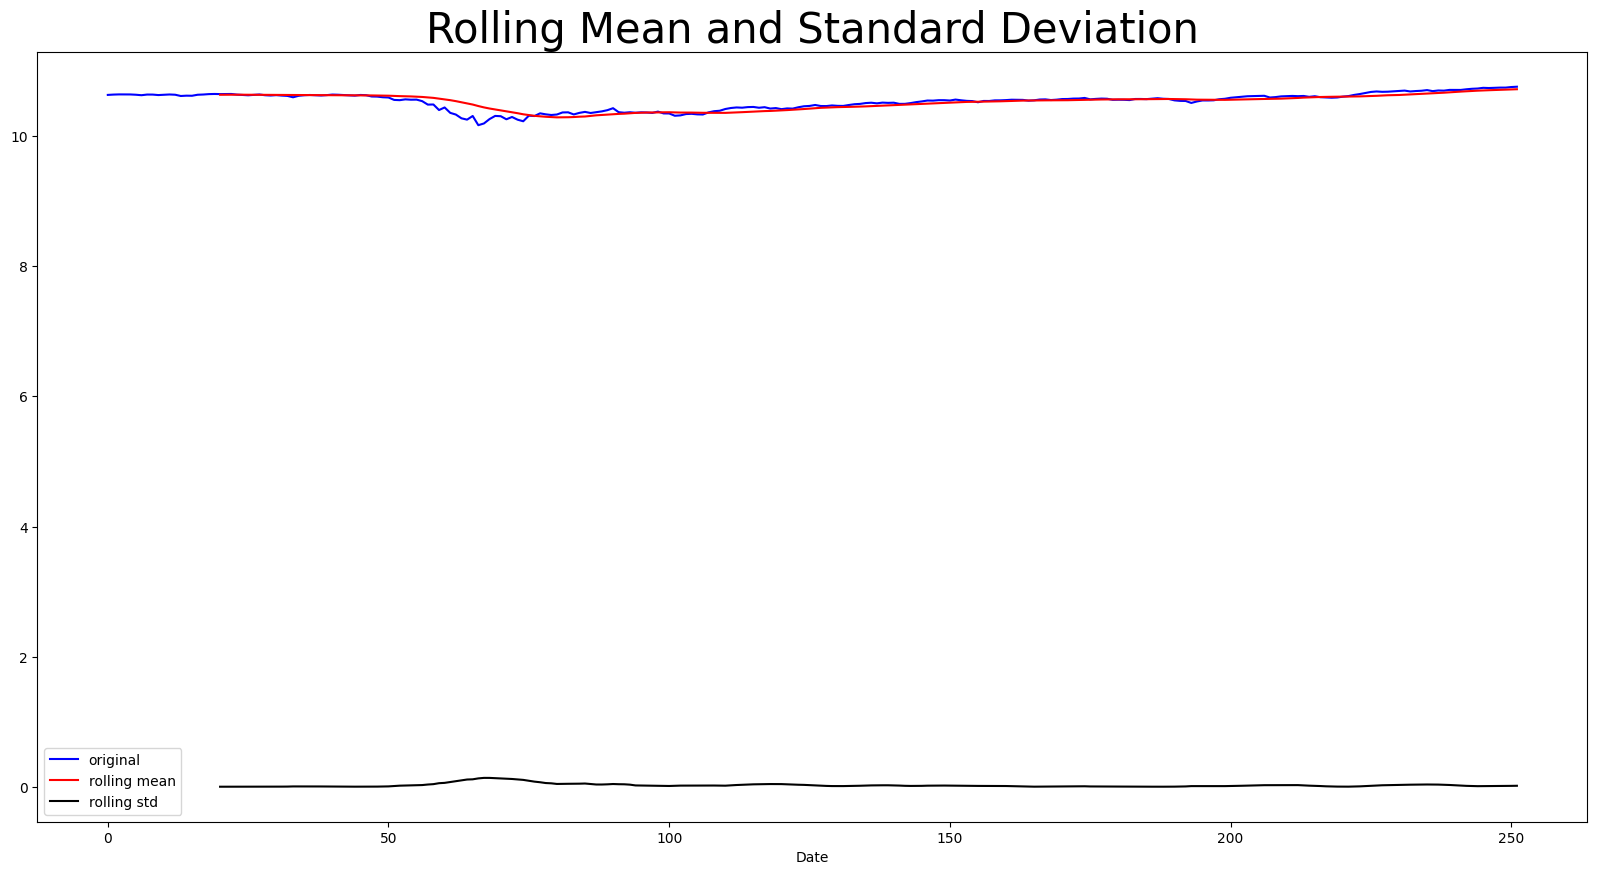

Results of dickey fuller test


NameError: name 'adfuller' is not defined

In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

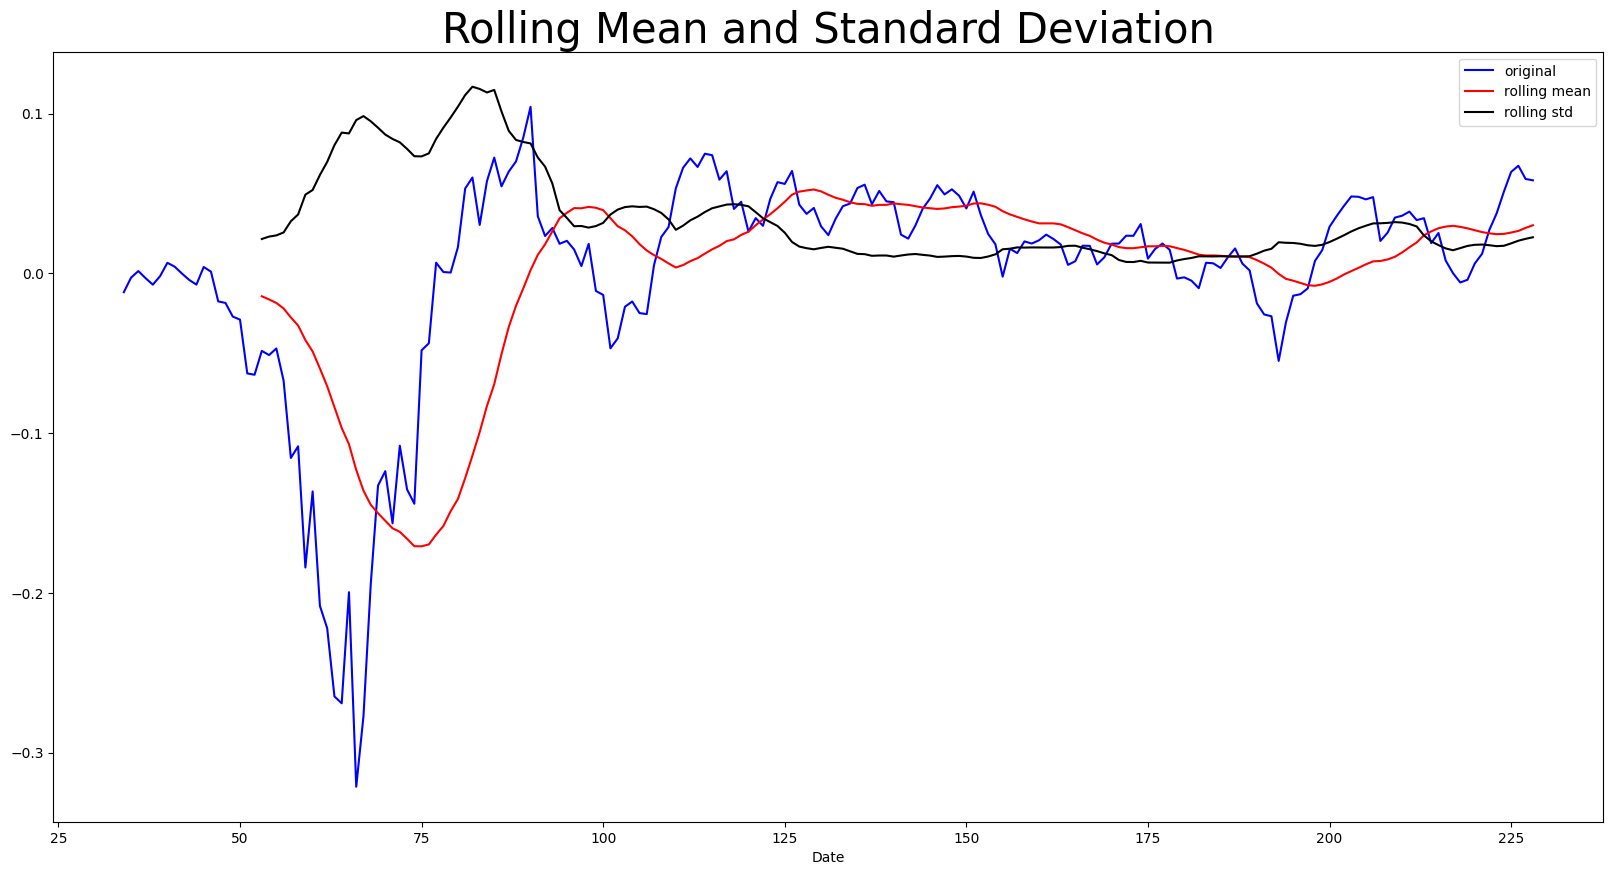

Results of dickey fuller test


NameError: name 'adfuller' is not defined

In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)


In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])